
# Projet TP 1

## TODO:
- Do exercise 1 and 2.
- In exercise 3.3 better understand on what they want me to comment on. 
- In exercise 4, compute stability criterion by hand. 
- In exercise 5, chose different schemas and comment on their rates of convergence given the parameters. 

## Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import norm
import seaborn as sns

## Constants

In [2]:
T = 0.75
a = 1
lmbda = 0.8
J = 20
# Possible schemes: ["centered", "left", "right, "Lax-Friedrichs", "Lax-Wendroff"]
approx_scheme = "Lax-Wendroff" # Try for different schemes
def uinit(x):
    return np.sin(2*np.pi*x)
def ubar(x,t):
    return uinit(x-a*t)

## Exercise 3

The space is discretized in one 1-period of our physical domain: $[0,1)$ with $J$ points, $(x_j)_{1<j<J}$. The time discretization will depend on the space-time-step ratio $\lambda$ we choose. The resulting Q matrix will be circulant because of the periodicity: 
- The first weight $c_{-1}$ will multiply the last spatial point $x_J$ in the last row of our system. 
- The last weight $c_{1}$ will multiply the first spatial point $x_0$ in the last row of our system. 

In [3]:
def discretize_space(J, lmbda, T):
    dx = 1/J
    dt = lmbda*dx
    M = int(T/dt)
    x = np.linspace(0, 1-dx, J) 
    return dx, dt, x, M

def compute_scheme_weights(lmbda, a):
    schemes = {
        "centered": np.array([
            lmbda * a / 2,
            1,
            -lmbda * a / 2
        ]),
        "left": np.array([
            lmbda * a,
            1 - lmbda * a,
            0
        ]),
        "right": np.array([
            0,
            1 + lmbda * a,
            -lmbda * a
        ]),
        "Lax-Friedrichs": np.array([
            0.5 + 0.5 * lmbda * a,
            0,
            0.5 - 0.5 * lmbda * a
        ]),
        "Lax-Wendroff": np.array([
            0.5 * lmbda * a + 0.5 * lmbda**2 * a**2,
            1 - lmbda**2 * a**2,
            - 0.5 * lmbda * a + 0.5 * lmbda**2 * a**2
        ])
    }
    return schemes

def generate_Q(cm1, c0, c1, J):
    Q = np.zeros((J, J))
    # Fill in the diagonals with weights
    for j in range(J):
        Q[j, j] = c0  # Main diagonal
        Q[j, (j - 1) % J] = cm1  # Sub-diagonal (wrap around with % operator)
        Q[j, (j + 1) % J] = c1   # Super-diagonal (wrap around with % operator)
    return Q

def scheme(dt, dx, x, M, cm1, c0, c1):
    Q = generate_Q(cm1, c0, c1, len(x)) 
    u_n = uinit(x)
    for n in range(0, M):
        u_n = Q.dot(u_n)
    ubar_n = ubar(x, M*dt)
    return u_n, ubar_n

def plot_solution(x, u_n, ubar_n, approx_scheme):
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(x, u_n, label="Numerical Solution $u_n$", marker='o')
    plt.plot(x, ubar_n, label="Analytical Solution $\\bar{u}_n$", linestyle='--')
    plt.xlabel("$x$")
    plt.ylabel("Solution Value")
    plt.title(f"Numerical vs Analytical Solution of '{approx_scheme}' method")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

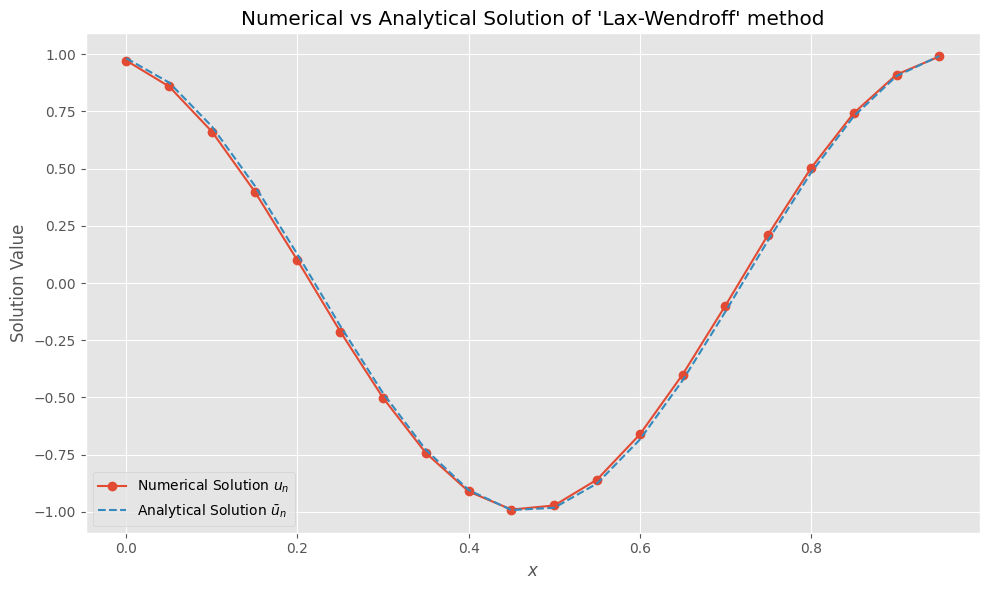

In [4]:
dx, dt, x, M = discretize_space(J, lmbda, T)
scheme_weights = compute_scheme_weights(lmbda, a)
weights = scheme_weights[approx_scheme]
u_n, ubar_n = scheme(dt, dx, x, M, weights[0], weights[1], weights[2])
plot_solution(x, u_n, ubar_n, approx_scheme)

## Exercise 4

In [5]:
def compute_scheme_norms(lmbda, a, J):
    weights = compute_scheme_weights(lmbda, a)
    norms_df = pd.DataFrame(columns=["infinity_norm", "2_norm"], index=weights.keys())
    # Loop over each scheme to generate Q and compute norms
    for scheme, coeffs in weights.items():
        # Generate Q using the scheme's weights
        cm1, c0, c1 = coeffs
        Q = generate_Q(cm1, c0, c1, J)
        # Compute norms and store in dataframe
        infinity_norm = norm(Q, ord=np.inf)  # Infinity norm
        two_norm = norm(Q, ord=2)            # 2-norm
        norms_df.loc[scheme] = [infinity_norm, two_norm]
    return norms_df

In [6]:
norms_df = compute_scheme_norms(lmbda, a, J)
print(norms_df)

               infinity_norm    2_norm
centered                 1.8  1.280625
left                     1.0       1.0
right                    2.6       2.6
Lax-Friedrichs           1.0       1.0
Lax-Wendroff            1.16       1.0


It can be noticed that:
- The centered scheme is unstable in both norms.
- The left scheme is stable in both norms since it respects the CFL condition and $a>0$. 
- The right scheme is unstable in both norms because $a>0$ (it must be negative for stabilty). 
- The Lax-Friedrichs method is stable in both norms.
- THe Lax-Wendroff is unstable in the infinity-norm, but stable in the 2-norm.

Now, let's compute the conditions for stability analytically. 

## Exercise 5

In [7]:
def scheme(dt, dx, x, M, cm1, c0, c1):
    Q = generate_Q(cm1, c0, c1, len(x)) 
    u_n = uinit(x)
    error_2_norms = []
    error_inf_norms = []
    for n in range(M):
        u_n = Q.dot(u_n)
        ubar_n = ubar(x, (n + 1) * dt)  # Compute ubar_n for the current timestep
        # Compute norms for the current timestep
        error_2_norm = np.sqrt(dx) * norm(ubar_n - u_n, ord=2)
        error_inf_norm = norm(ubar_n - u_n, ord=np.inf)
        # Store the norms
        error_2_norms.append(error_2_norm)
        error_inf_norms.append(error_inf_norm)
    # Get the maximum norms across all timesteps
    max_error_2_norm = max(error_2_norms)
    max_error_inf_norm = max(error_inf_norms)
    return u_n, ubar_n, max_error_2_norm, max_error_inf_norm 

In [8]:
J_list = [25, 50, 100, 200]
dx_list = np.zeros((len(J_list), 1))
error_2_norm_list = np.zeros((len(J_list), 1))
error_inf_norm_list = np.zeros((len(J_list), 1))
scheme_weights = compute_scheme_weights(lmbda, a)
weights = scheme_weights[approx_scheme]

# Loop over each grid size to calculate error norms
for i in range(0, len(J_list)):
    # Discretize space and time based on the current grid size
    dx, dt, x, M = discretize_space(J_list[i], lmbda, T)#
    dx_list[i] = dx
    # Compute numerical solution, exact solution, and error norms
    u_n, ubar_n, error_2_norm, error_inf_norm = scheme(dt, dx, x, M, weights[0], weights[1], weights[2])
    error_2_norm_list[i] = error_2_norm
    error_inf_norm_list[i] = error_inf_norm

Slope (Order of Accuracy) for L2 Norm: 1.9890998309607735
Slope (Order of Accuracy) for L-infinity Norm: 1.988333741432406


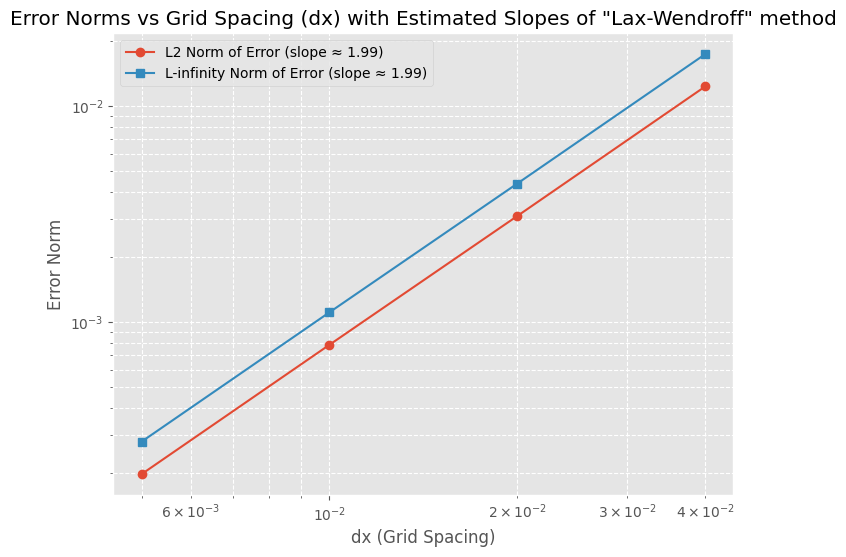

In [9]:
# Log of dx and error norms
log_dx = np.log(dx_list).flatten()
log_error_2 = np.log(error_2_norm_list).flatten()
log_error_inf = np.log(error_inf_norm_list).flatten()
# Find the slope of errors
slope_2, intercept_2 = np.polyfit(log_dx, log_error_2, 1)
slope_inf, intercept_inf = np.polyfit(log_dx, log_error_inf, 1)
# Display the slopes (which indicate the convergence order)
print(f"Slope (Order of Accuracy) for L2 Norm: {slope_2}")
print(f"Slope (Order of Accuracy) for L-infinity Norm: {slope_inf}")
# Plot with estimated slopes
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
plt.loglog(dx_list, error_2_norm_list, 'o-', label=f'L2 Norm of Error (slope ≈ {slope_2:.2f})')
plt.loglog(dx_list, error_inf_norm_list, 's-', label=f'L-infinity Norm of Error (slope ≈ {slope_inf:.2f})')
plt.xlabel('dx (Grid Spacing)')
plt.ylabel('Error Norm')
plt.title(f'Error Norms vs Grid Spacing (dx) with Estimated Slopes of "{approx_scheme}" method')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
